![title](dataset-cover.png)

Cancer remains as one of the most difficult diseases to treat in the history of the medical field. It is important to analyze how much this disease affect different people in the world in order to be informed on how we could approach this issue. This dataset contains cancer-related patient data collected from various hospital regions. It includes demographic details, lifestyle factors, cancer diagnostics, treatment information, and outcomes for 17,686 patients. The data is structured to facilitate analysis of patterns in cancer diagnosis, treatment efficacy, and survival outcomes.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf

cancer = pd.read_csv('cancer issue.csv')
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17686 entries, 0 to 17685
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientID          17686 non-null  int64  
 1   Age                17686 non-null  int64  
 2   Gender             17686 non-null  object 
 3   Race/Ethnicity     17686 non-null  object 
 4   BMI                17686 non-null  float64
 5   SmokingStatus      17686 non-null  object 
 6   FamilyHistory      17686 non-null  object 
 7   CancerType         17686 non-null  object 
 8   Stage              17686 non-null  object 
 9   TumorSize          17686 non-null  float64
 10  TreatmentType      17686 non-null  object 
 11  TreatmentResponse  17686 non-null  object 
 12  SurvivalMonths     17686 non-null  int64  
 13  Recurrence         17686 non-null  object 
 14  GeneticMarker      13360 non-null  object 
 15  HospitalRegion     17686 non-null  object 
dtypes: float64(2), int64(3

Cleaning and creating categorical data:

In [55]:
cancer_transform = cancer.copy()

def to_category(column, order = None):
    """
    Convert a column to a category type.

    Parameters:
    column (str): The name of the column to convert.
    order (list) [optional]: The order of the categories.

    Returns:
    None
    """
    if order == None:
        cancer_transform[column] = cancer_transform[column].astype('category')
    else:
        cancer_transform[column] = cancer_transform[column].astype('category').cat.set_categories(order, ordered = True)

def to_int32(column):
    """
    Convert a column to an int32 type.

    Parameters:
    column (str): The name of the column to convert.

    Returns:
    None
    """
    cancer_transform[column] = cancer_transform[column].astype('int32')

def to_float16(column):
    """
    Convert a column to a float16 type.

    Parameters:
    column (str): The name of the column to convert.

    Returns:
    None
    """
    cancer_transform[column] = cancer_transform[column].astype('float16')

to_category('Gender')

cancer_transform.rename(columns = {'Race/Ethnicity' : 'Race'}, inplace= True)
to_category('Race')

to_category('SmokingStatus')
to_category('FamilyHistory')
to_category('CancerType')
to_category('Stage', order = ['I', 'II', 'III', 'IV'])
to_category('TreatmentType')
to_category('TreatmentResponse', order = ['No response', 'Partial remission', 'Complete remission'])
to_category('Recurrence')
to_category('GeneticMarker')
to_category('HospitalRegion')

to_int32('Age')
to_int32('PatientID')
to_int32('SurvivalMonths')

to_float16('BMI')
to_float16('TumorSize')

Visualizing the difference of survivability of patient from each cancer type filtered by gender.

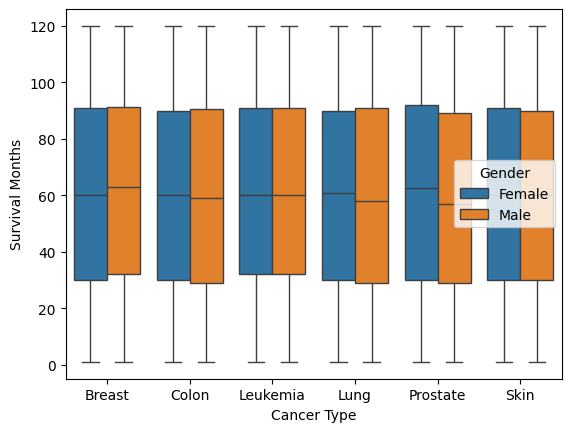

In [56]:
g = sns.boxplot(x = 'CancerType', y = 'SurvivalMonths', data = cancer_transform, hue = 'Gender')
g.set(xlabel = 'Cancer Type', ylabel = 'Survival Months')

plt.show()

C:\Users\Carlos Miguel\AppData\Local\Temp\ipykernel_17672\446597179.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancer_asians_survmonths = cancer_asians.groupby('CancerType')['SurvivalMonths'].mean()


CancerType
Breast      61.018425
Colon       57.825939
Leukemia    61.434483
Lung        60.333333
Prostate    57.767101
Skin        61.023179
Name: SurvivalMonths, dtype: float64


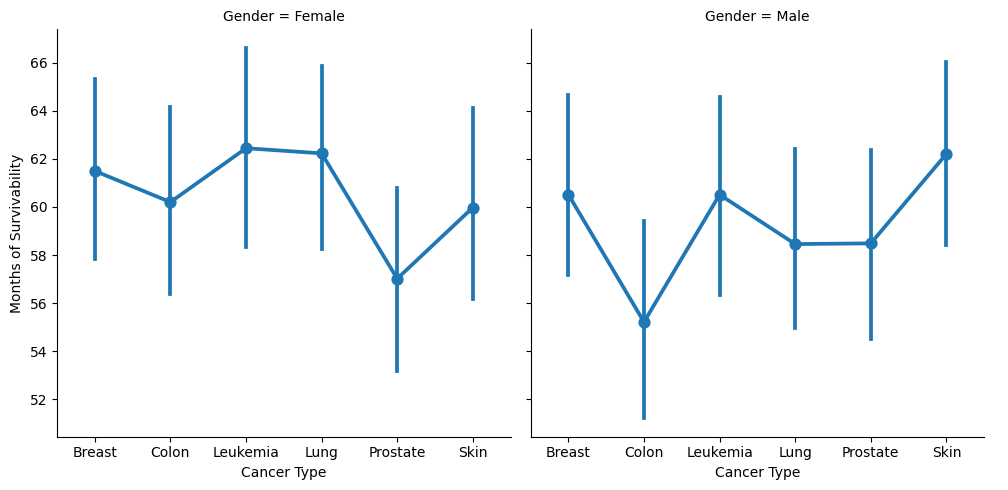

In [57]:
cancer_asians = cancer_transform[cancer_transform['Race'] == 'Asian']

cancer_asians_survmonths = cancer_asians.groupby('CancerType')['SurvivalMonths'].mean()
print(cancer_asians_survmonths)

g = sns.catplot(x = 'CancerType', y = 'SurvivalMonths', data = cancer_asians, kind = 'point', col = 'Gender')
g.set_axis_labels('Cancer Type', 'Months of Survivability')
plt.show()
plt.show()

The point plot above shows the difference between months of survivability of patient with the different cancer types that they have. As shown, female patients with prostate cancer have lesser months of survivability while male patients with colon cancer have lesser months of survivability as well.

Setting Samples:

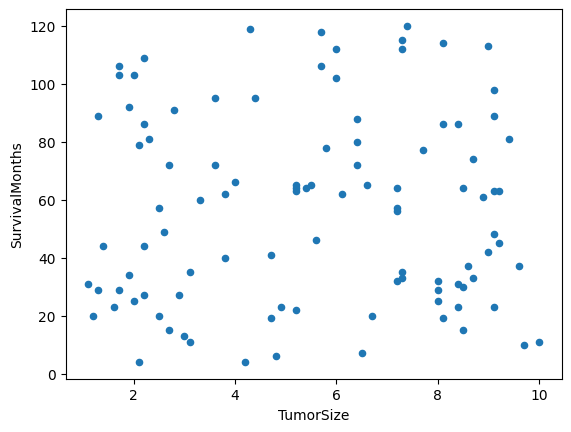

In [58]:
sample_size = 100

shuffled = cancer_transform.sample(frac = 1).reset_index(drop = True).reset_index()
pop_size = len(shuffled)
interval = pop_size // sample_size

cancer_interval = cancer_transform.iloc[::interval]

cancer_interval.plot(x = 'TumorSize', y = 'SurvivalMonths', kind = 'scatter')
plt.show()

As shown it shows that tumor size has a low correlation with the months of survivability of a patient.

In [59]:
cancer_transform['Race'].value_counts(normalize = True)

Race
Asian               0.203494
Hispanic            0.202137
African American    0.200215
Other               0.197840
Caucasian           0.196313
Name: proportion, dtype: float64

In [60]:
# Convert categorical columns to numeric codes
categorical_columns = cancer_transform.select_dtypes(['category']).columns

for column in categorical_columns:
    cancer_transform[column] = cancer_transform[column].cat.codes

age_bins = [0, 16, 32, 48, 64, 80, 96]
age_labels = [0, 1, 2, 3, 4, 5]

cancer_transform['Age'] = pd.cut(cancer_transform['Age'], bins=age_bins, labels=age_labels)

In [66]:
#Modeling

models = []

features = 'Age', 'Gender', 'Race', 'BMI', 'TumorSize', 'SmokingStatus', 'FamilyHistory', 'CancerType', 'Stage', 'GeneticMarker'

for feature in features:
    feature_formula = 'Recurrence ~ ' + feature
    model = smf.logit(formula = feature_formula, data = cancer_transform).fit()
    models.append(model)

accuracies = []

for model in models:
    conf_matrix = model.pred_table()
    TP,TN,FP,FN = conf_matrix[1,1], conf_matrix[0,0], conf_matrix[0,1], conf_matrix[1,0]
    accuracy_score = (TN + TP) / (TN + TP + FN + FP)
    accuracies.append(accuracy_score)

feature_accuracies = pd.DataFrame({'Feature': features, 'Accuracy': accuracies})

display(feature_accuracies)

         Current function value: 0.692990
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693114
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693141
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693023
         Iterations 3


c:\Users\Carlos Miguel\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Feature,Accuracy
0,Age,0.507350
1,Gender,0.501527
2,Race,0.502997
3,BMI,0.501018
4,TumorSize,0.503449
5,SmokingStatus,0.501527
6,FamilyHistory,0.501527
7,CancerType,0.501640
8,Stage,0.501527
9,GeneticMarker,0.507294
